# Explore Off-sample results

## Setup

In [1]:
%load_ext autoreload
%autoreload 2

In [3]:
%matplotlib inline
from matplotlib import pyplot as plt
import pandas as pd
from metaspace import SMInstance

sm_inst = SMInstance()
sm_inst

SMInstance(https://metaspace2020.eu/graphql)

## Fetch Search Results

In [3]:
# ds_id = '2018-10-16_16h42m00s'
ds_name = 'Testing MS Staging_LK_CMC+LN2_N2_50um'
fdr = 0.2
moldb_name = 'HMDB-v4'
ds = sm_inst.dataset(name=ds_name)
ds

SMDataset(Testing MS Staging_LK_CMC+LN2_N2_50um | ID: 2018-10-31_21h18m02s)

In [4]:
len(ds.annotations(fdr=fdr))

465

In [5]:
%%time
ds_images = ds.all_annotation_images(fdr=fdr, database=moldb_name)
len(ds_images)

CPU times: user 28.7 s, sys: 1.91 s, total: 30.6 s
Wall time: 18.8 s


In [13]:
imgs = ds_images[0]

In [6]:
ann_docs = []
for img in ds_images:
    formula = img._sf
    adduct = img._adduct
    ann_docs.append({
        'formula': formula,
        'adduct': adduct,
        'image': next(iter(img)),
        'image_url': img._urls[0],
    })
len(ann_docs)

465

In [7]:
ann_docs[0]

{'formula': 'C40H80NO8P',
 'adduct': '+H',
 'image': array([[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]], dtype=float32),
 'image_url': '/fs/iso_images/0998823a5324dfa49a60edccca2af6f2'}

## Fetch Off-sample Predictions

In [8]:
ds = sm_inst.dataset(name=ds_name)

In [25]:
anns = ds.annotations(fdr=fdr, database=moldb_name,
                      return_vals=('sumFormula', 'adduct', 'offSample', 'offSampleProb'))
off_sample_preds = {(formula, adduct): off_sample for (formula, adduct, *off_sample) in anns}
len(off_sample_preds)

465

In [30]:
for ann in ann_docs:
    label, prob = off_sample_preds[(ann['formula'], ann['adduct'])]
    ann['label'] = label
    ann['prob'] = prob

## Visualize and Compare

In [31]:
def plot_images(images, labels, limit=20, coln=4):
    limit = min(limit, len(images))
    rown = (limit - 1) // coln + 1

    fig, axes = plt.subplots(rown, coln, figsize=(5*coln, 5*rown))
    for i in range(rown):
        for j in range(coln):
            idx = i * coln + j
            if idx < limit:
                ax = axes[i, j] if axes.ndim > 1 else axes[j]
                ax.imshow(images[idx], cmap='viridis');
                ax.set_title(labels[idx])
    plt.show()

In [51]:
def ann_to_images_labels(anns):
    images = [d['image'] for d in anns]
    
    labels = []
    for d in anns:
        label = 'off' if d['label'] else 'on'
        prob = d['prob']
        formula, adduct = d['formula'], d['adduct']
        labels.append(f'{formula} {adduct}\nlabel: {label}, off prob: {prob:.3f}')
    
    return images, labels

In [52]:
off_ann_docs = [d for d in ann_docs if d['prob'] > 0.5]
len(off_ann_docs)

97

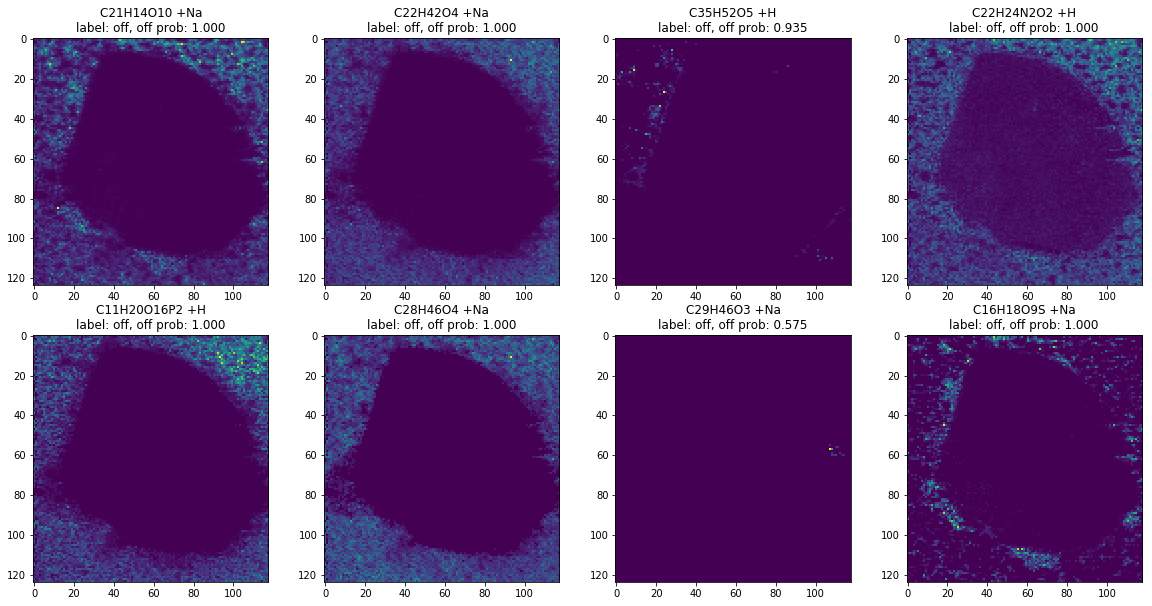

In [53]:
images, labels = ann_to_images_labels(off_ann_docs)
plot_images(images, labels, limit=8)

In [54]:
on_ann_docs = [d for d in ann_docs if d['prob'] < 0.5]
len(on_ann_docs)

368

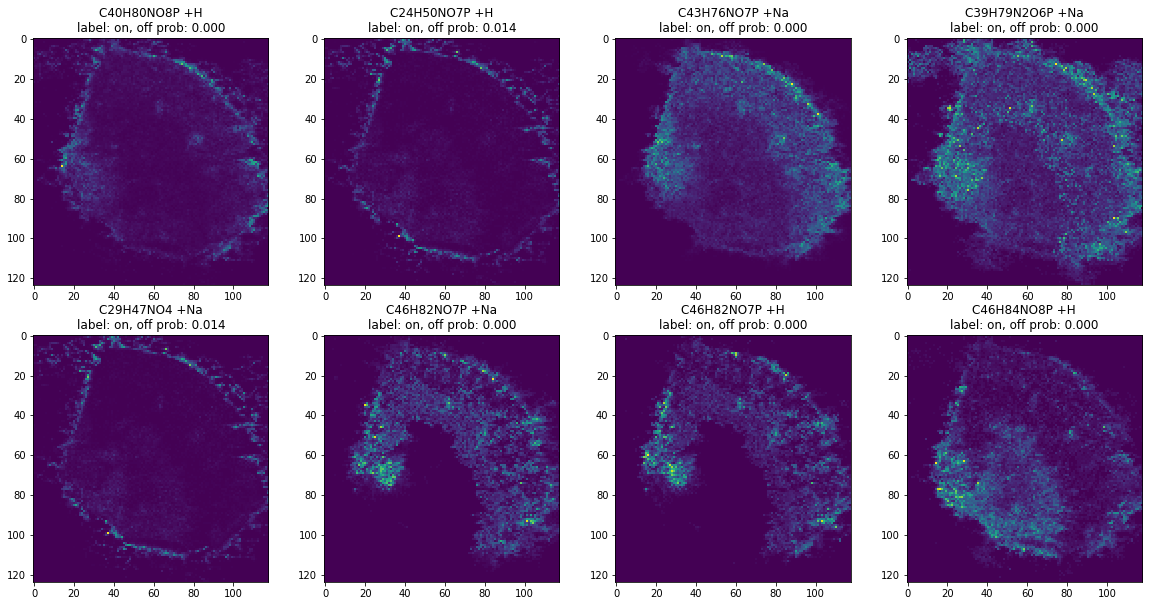

In [55]:
images, labels = ann_to_images_labels(on_ann_docs)
plot_images(images, labels, limit=8)

In [56]:
border_ann_docs = [d for d in ann_docs if 0.4 < d['prob'] < 0.6]
len(border_ann_docs)

18

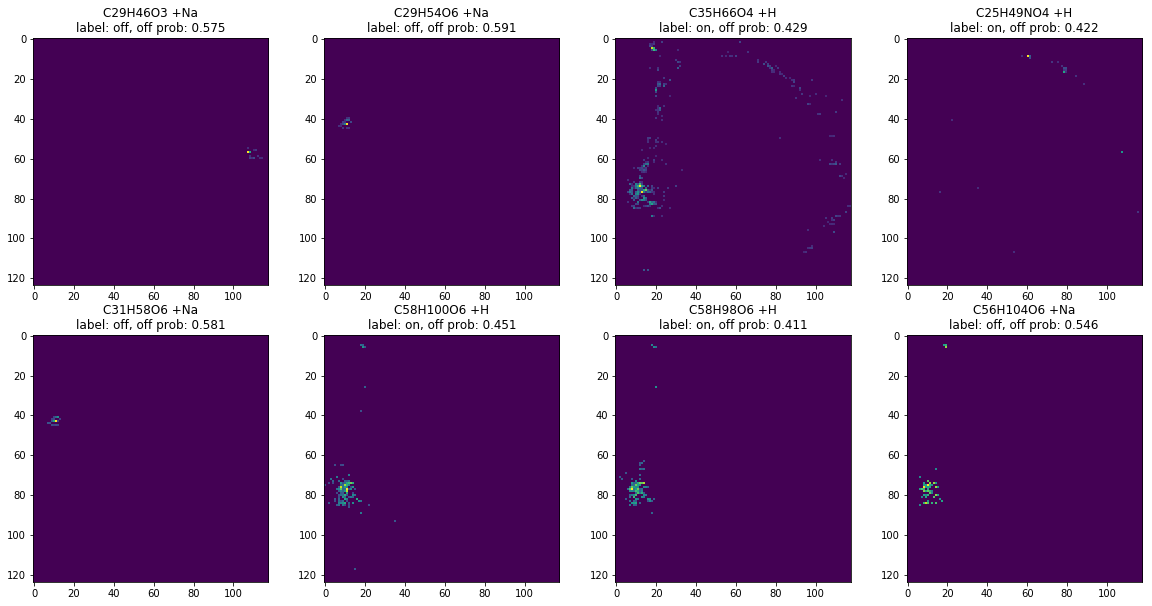

In [57]:
images, labels = ann_to_images_labels(border_ann_docs)
plot_images(images, labels, limit=8)

## Call Off-Sample Service

In [42]:
from PIL import Image
import numpy as np

In [43]:
from sm.engine.postprocessing.off_sample_wrapper import make_classify_images, numpy_to_pil

In [46]:
api_endpoint = 'http://off-sample-api-load-balancer-630496755.eu-west-1.elb.amazonaws.com/off-sample'
classify_images = make_classify_images(api_endpoint, numpy_to_pil)

In [47]:
%%time
images = [d['image'] for d in ann_docs]
preds = classify_images(images)

CPU times: user 636 ms, sys: 196 ms, total: 832 ms
Wall time: 32.3 s


In [62]:
len(preds)

465

In [66]:
%%time
images = [d['image'] for d in off_ann_docs]
preds = classify_images(images)

CPU times: user 107 ms, sys: 603 µs, total: 108 ms
Wall time: 11.8 s


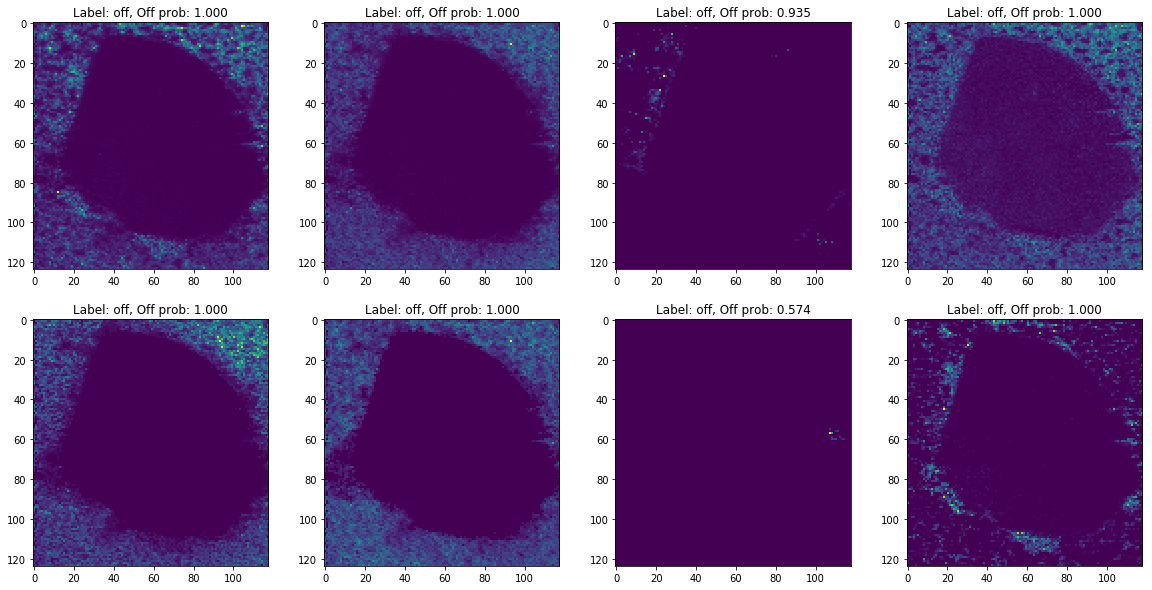

In [68]:
labels = ['Label: {}, Off prob: {:.3f}'.format(p['label'], p['prob']) for p in preds]
plot_images(images, labels, limit=8)

The difference between off-sample predictions saved in the database `off_ann_docs` and fresh off-sample predictions `preds` can potentially be explained by intensity scaling applied to all images inside `python-client`

In [73]:
n = 20
for ann, pred in zip(off_ann_docs[:n], preds[:n]):
    print(ann['formula'], ann['adduct'])
    if not np.isclose(ann['prob'], pred['prob']):
        print(ann['prob'], pred['prob'])

C21H14O10 +Na
C22H42O4 +Na
C35H52O5 +H
C22H24N2O2 +H
C11H20O16P2 +H
C28H46O4 +Na
C29H46O3 +Na
0.5751572251319885 0.5739261507987976
C16H18O9S +Na
C18H18O11 +K
C25H22O14 +K
C27H20O21S +H
C33H53NO6 +Na
0.9876047372817993 0.9872623085975647
C18H10O6 +K
C29H54O6 +Na
0.5912410020828247 0.5903647541999817
C10H16N4O7S +H
C21H24O7 +Na
0.8695191740989685 0.8690138459205627
C35H52O6 +H
0.9322258234024048 0.9321801662445068
C69H134O6 +H
C11H23O7P +K
C15H30N6O4 +H
